# **2. Programming: Histogram of Oriented Gradients and convolutions (100 points)**

### **2.0 Convolution function** (24 points)

Convolutions are important mathematical operations where a function is modified by a second one. In a discrete setting, convolution and cross-correlation can be used to apply diverse kernels in multi-dimensional matrices (e.g., images). In this part of the assignments you are asked to mannualy implement a function that executes a convolution (actually cross correlation: read note in the next code block).  

In [ ]:
READ_THE_INSTRUCTIONS_FLAG = True

In [ ]:
from matplotlib import pyplot as plt
from skimage.feature import hog
from skimage import data, exposure
import sys
import cv2
import os
import numpy as np

print('-'*40)
print ('Python version: {}'.format(sys.version))
print('OpenCV version: {}'.format(cv2.__version__))

if not READ_THE_INSTRUCTIONS_FLAG:
  raise Exception('Please go back and read the instructions.')
else:
  print('\nThank you for reading the instructions.')
print('-'*40)

# helper functions

def pltImg(img, title=None, ori="horizontal", colorb = True, color_map='gray'):  # not mandatory, but useful
  plt.imshow(img,cmap=color_map)
  if colorb:
    plt.colorbar(orientation=ori)
  if title:
    plt.title(title)
  return plt

# TO-DO (15 points): Implement a function that performs a convolution following the skeleton provided. You 
# should use a maximum of ksize*ksize iterations in your "for" loop. For example: given a 
# 3x3 kernel, you can use a maximum of 9 iterations on your convolution's "for" loop. Your 
# function should accept input matrices of any size, as long as they are at least the 
# same size as the convolutional kernel.   

def my_padded_conv2D(kernel, matrix, pad_value=0):
  # steps: 
  # 1. create a matrix to receive the results
  result = np.zeros(matrix.shape, np.float32)

  # 2. pad the image with the constant value indicated (default 0) based on the kernel provided
  pad_amount = tuple(round(i / 2 - 0.5) for i in kernel.shape)
  matrix_padded = np.pad(matrix, pad_amount, mode='constant', constant_values=pad_value)

  # 3. fill the "result" matrix using a maximum of ksize*ksize iterations (e.g., for 
  # a 3x3 kernel, a maximum of 9 iterations in a loop)

  height, width = result.shape
  u, v = kernel.shape

  for i in range(height):
    for j in range(width):
      result[i][j] = np.sum(np.multiply(matrix_padded[i:i+u, j:j+v], kernel))
    
  assert (result.shape == matrix.shape),'The dimensions of input and output should be the same.'
  return result

# Note 1: we are implementing a convolution function that uses padding so that the 
# output image does not change its dimensions. As mentioned in Lecture 6, in some feature extraction
# networks and many other settings this is not the desired behaviour (i.e., images
# are supposed to change their dimensions).

# Note 2: consider that the input kernels are square matrices with an odd number of 
# rows and columns (e.g., 3x3, 5x5, 7x7, 9x9). 

# Note 3: for simplicity (and to conform with most functions from popular libraries)
# we are actually implementing a cross-correlation operation. Remember: to
# implement a proper convolution, it suffices to rotate a kernel around its
# center (i.e., horizontal then vertical reflection). More details provided in the following
# code cell.

----------------------------------------
Python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
OpenCV version: 4.1.2

Thank you for reading the instructions.
----------------------------------------


In [ ]:
# TO-DO (9 points total): test your convolution function with the three scenarios created below. 
# We will use OpenCV's filter2D function as a reference for the desired, correct results. 

# Note: both your "my_padded_conv2D" function and OpenCV's "cv2.filter2D" are actually implementing cross correlation, as
# stated in OpenCV's documentation of the function: "The function does actually compute correlation,
# not the convolution" (https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04)
# To implement convolution, you would simply rotate the kernel to be used with your function 180 degrees. This is not 
# necessary in this assignment.   

# Scenario 1 (3 points) - simple 3x3 identity matrix kernel and square input matrix
kernel1 = np.eye(3).astype(np.float32)
input1 = np.arange(1,26).reshape((5,5)).astype(np.float32)
result1 = my_padded_conv2D(kernel1,input1)
result1_reference = cv2.filter2D(input1, -1, kernel1, borderType=cv2.BORDER_CONSTANT)
assert (result1_reference == result1).all(), 'Incorrect result in scenario 1.'

# Scenario 2 (3 points) - simple 5x5 identity matrix kernel and WxH input matrix
kernel2 = np.eye(5).astype(np.float32)
input2 = np.arange(1,8193).reshape((128,64)).astype(np.float32)
result2 = my_padded_conv2D(kernel2,input2)
result2_reference = cv2.filter2D(input2, -1, kernel2, borderType=cv2.BORDER_CONSTANT)
assert (result2_reference == result2).all(), 'Incorrect result in scenario 2.'

# Scenario 3 (3 points) - 7x7 random-valued kernel with WxH random-valued matrix
kernel3 = np.random.randint(1, 1000, 49).reshape(7, 7).astype(np.float32)
input3 = np.random.randint(1, 1000, 200).reshape(10, 20).astype(np.float32)
result3 = my_padded_conv2D(kernel3,input3)
result3_reference = cv2.filter2D(input3, -1, kernel3, borderType=cv2.BORDER_CONSTANT)
assert (result3_reference == result3).all(), 'Incorrect result in scenario 3.'

print('All results are correct!')

All results are correct!


### **2.1 HOG: Pre-processing, magniture and orientation calculation** (20 points)

**Introduction**: Histogram of oriented gradients (HOG) are popular feature descriptors made hugely popular when used for pedestrian detection in 2005 [1]. These feature descriptors are obtained as the output of an intricate computational pipeline which will be discussed during class (week of Feb. 8), and should be implemented in this part of the assignment. We are going to manually implement all steps until the "Linear SVM" phase of the method (see Figure below from [1]).   

[1] Dalal N, Triggs B. Histograms of oriented gradients for human detection. In 2005 IEEE computer society conference on computer vision and pattern recognition (CVPR'05). 2005 Jun 20 (Vol. 1, pp. 886-893). IEEE.

![HOG Pipeline](https://raw.githubusercontent.com/tunai/storage/master/images/teaching/ece%20473-536/A2/hog_pipeline.jpg)

**Note**: a number of image processing libraries provide efficient and easy-to-use implementations of the Histogram of Oriented Gradients. Although these are recommended for general use, the goal of this assignment is to provide a deeper understanding of the algorithmn as well as an opportunity for hands-on experience in implementing complete Computer Vision pipelines. We are going to compare our results with those from an available implementation later.

**Pre-processing, magniture and orientation calculation**: the choice of color space and use of gamma equalization does not significantly change the performance of the method [1]. Therefore, we are going to skip the gamma correction step. The use of grayscale images only "reduces performance by 1.5%" [1], thus we are going to use that approach for simplicity.  

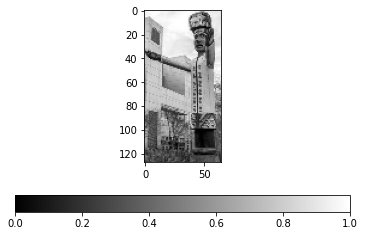

In [ ]:
# TO-DO (3 points): Read the image from the address indicated and turn it to grayscale. 
# Resize the image to (64,128) and normalize its pixel intensity values to the [0,1] range. 
# Plot the image after this pre-processing. 

# note 1: check if the image was already downloaded first.
# note 2: for consistency between results, resize the image using the "cv2.INTER_CUBIC"
# interpolation parameter

img_add = "https://raw.githubusercontent.com/tunai/storage/master/images/teaching/ece%20473-536/A2/uvic_totem.jpg"

#
# 0. check if image was previously downloaded
# if not, download it

filename = os.path.split(img_add)[-1]

if not os.path.isfile(filename):
  output = os.system('wget -nc ' + img_add)

# 1. read the image
img = cv2.imread(filename, 0)

# 2. resize the image
img = cv2.resize(img, (64,128), interpolation=cv2.INTER_CUBIC)

# 3. normalize the image in the [0,1] range
#img = (img/255).astype('float32')
img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX,  cv2.CV_32F)

cell_size = 8  # 8x8 pixels cells where the histograms of oriented gradients are going to be calculated
n_bin = 9  # number of bins of a given histogram. According to [1], n_bin > 9 did not significantly increase performance. 

# plot the image
_ = pltImg(img)

In [ ]:
# The authors of [1] used diverse kernels for gradient detection: "We tested 
# gradients computed using Gaussian smoothing followed by one of several discrete derivative masks." 
# However they found that a simple 1-D centered point derivative kernel (i.e., [-1,0,1]) works best. This 
# is what we are going to use.
# Note: using uncentered 1-D point derivative kernels (i.e., [-1,1]: forward and backward difference-based 
# approximations of first-order derivatives) decreased performance in 1.5% [1].

# TO-DO (3 points): define a 1-D centered point derivative kernel (i.e., first order derivative approximation using
# central differences; see Lecture 6) for the calculation of the x-axis gradient ("Gradient in x, G_x") and y-axis gradient
# ("Gradient in y, G_y").
# Apply these kernels to the input image using your "my_padded_conv2D" function. 
# Note: since your function expects square inputs, pad the kernels created with zeros if necessary. 

kernel_x = np.matrix([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
kernel_y = np.matrix([[0, -1, 0], [0, 0, 0], [0, 1, 0]])

gradient_x = my_padded_conv2D(kernel_x, img)
gradient_y = my_padded_conv2D(kernel_y, img)

# TO-DO (13 points): MANUALLY calculate the magnitude and orientation (in degress) matrices from the
# gradient images (i.e., you CAN NOT use cv2.cartToPolar or other functions). 
# The authors of [1] used the "unsigned" gradient (from 0 to 180 degrees, instead of
# 0 to 360 degrees). Do the same by adjusting your mannualy calculated orientation 
# angles (in degrees) to [0,180]. A reference for the first 9 elements of the orientation matrix is provided
# below.  

**Recall**: The magnitude of gradient image $\triangledown I$ is defined as:

$|\triangledown I| = \sqrt{(\frac{\delta I}{\delta x})^2+(\frac{\delta I}{\delta y})^2}$

Consider $\triangledown I_x = \frac{\delta I}{\delta x}$ and $\triangledown I_y = \frac{\delta I}{\delta y}$ (gradients in x and in y). 

Orientation $\theta$ is defined as: 

$\theta = atan(\frac{\triangledown I_y}{\triangledown I_x})$

As a reference, this is how the first few elements of your orientation matrix
should look like:

orientation[0:3,0:3] = [[45.862453   89.516495   89.28976   ], [ 1.9333004  66.80141    70.34617   ], [ 0.23578373 26.56505     9.462321  ]]

[[45.862446   89.516495   89.28976   ]
 [ 1.9333003  66.80141    70.34617   ]
 [ 0.23578373 26.56505     9.462321  ]]


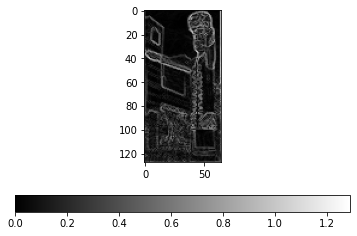

In [ ]:
mag = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
orientation = np.degrees(np.arctan2(gradient_y, gradient_x))

# Adjusting negative signed degrees to unsigned according to HOG lecture
orientation[orientation < 0] += 180 

print(orientation[0:3,0:3]) # check with the orientation reference provided. they should be 
# extremely similar

# TO-DO (1 point): plot the magniture matrix
#
_ = pltImg(mag)

### **2.2 HOG: Creation of cells and Histograms of Oriented Gradients** (26 points)

We now have the orientation and magnitude images (matrices) of our grayscale input. The next step is to divide the grayscale input into 8x8 non-overlapping cells and create, for each cell, a histogram of oriented gradients. The HOG formation is illustrated in the image below (considering a small 3x3 cell): 

![](https://raw.githubusercontent.com/tunai/storage/master/images/teaching/ece%20473-536/A2/hog_formation.jpg)

In [ ]:
# TO-DO (total 25 points): create the functions "my_hog" and "create_hist_cell" as specified
# in the templates below. 

# Tip: this implementation is going to be discussed during class on the week of February 8. 

# (10 points) my_hog function: this function is responsible for dividing the input image into non-overlapping
# cells of cell_size x cell_size.
def my_hog(img, cell_size, n_bin, mag, orientation):

  hog = []  # this is the list that will hold the HOG
  dims = img.shape # dimensions of the image
      
  # loop to divide the image into cells of cell_size x cell_size. Each cell is then 
  # used as input to the "create_hist_cell" function (see below). The output (HOG)  
  # is stored as a numpy ndarray in the "hog" list.
  #
  #
  for i in range(0, dims[0] - cell_size + 1, cell_size):

    for j in range(0, dims[1] - cell_size + 1, cell_size):

      # get 8x8 cells of magnitude
      mag_cells = mag[i:i+cell_size, j:j+cell_size]

      # get 8x8 cells of orientation
      orientation_cells = orientation[i:i+cell_size, j:j+cell_size]

      # feed them into create_hist_cell, and append it to my list of HOG
      hog.append(create_hist_cell(mag_cells, orientation_cells, n_bin))

  return hog


# (15 points): this function will create a histogram of n_bins (9 by default) positions
# where the histogram of oriented gradients of a 8x8 cell is going to be stored.
# You can USE A MAXIMUM of "bin_size" iterations on this function's internal loop. 

def create_hist_cell(mag, orientation, bin_size):

    # each cell is going to have its own histogram of size 1x"bin_size"

    hist = np.zeros(9) # creates the empty histogram
    factor = 20 # the increment between boundaries of each bin of the cell histogram
    limits = (0, 180) # the boundaries between bins of the histogram

    # loop to, given an orientation and magnitude cell (small patch of cell_size x cell_size)
    # create a HOG.
    # You can use a MAXIMUM of "bin_size" iterations in this loop 
    #
    #
    # As above up to "bin_size" iterations in this loop
    for i in range(bin_size):

      # sub select orientation angles between the bin sizes for each iteration 0 = [0,20), 1 = [20,40), ... , 8 = [160, 180)
      # note: we select inclusive bin angle (below as <=) in order to add values to previous hist bin if they fall on this boundry
      selected = (np.where((i*factor <= orientation) & (orientation < (i+1)*factor), mag, 0))
      
      # add sum of selected values to the current hist bin iteration
      hist[i] += np.sum(selected)

      # case to check if there are boundary values in our selection above
      # select the sub selected orientation values that are not on edge limits, and fall on current boundary
      boundary = np.where((selected != limits[0]) & (selected != limits[1]) & (selected % factor == 0), mag, 0)
      x= (selected != limits[0]) & (selected != limits[1]) & (selected % factor == 0)

      # add sum of them to the previous bin if any are boundaries found
      hist[i-1] += np.sum(boundary)
      # (note if there aren't boundary values, above line will just add 0s to previous bin which won't change the hist)

    # note: there exists different ways to fill the histograms of oriented gradients. Some 
    # implementations use a weighted voting scheme for each pixel (i.e., a pixel would contribute 
    # to more than a single bin to avoid bias), while others simply add the values of the last 
    # bin in the first one (e.g., orientations between 160-180 also contributing to the 0-20 bin).
    # For simplicity, we do not do that here. Therefore, this implementation can be considered as
    # an approximation of the algorithm in [1].
        
    assert len(hist) == bin_size, 'The number of bins in this output histogram is incorrect.'
    return hist

# TO-DO (1 point): use your my_hog function to extract the histograms of oriented gradients 
# from the input image.

my_hog = my_hog(img, cell_size, n_bin, mag, orientation)

# print(my_hog[0])
# Output: [4.74221754 0.17178032 2.08652806 0.70641959 7.67434216 0.68400109
# 1.39279175 0.78699005 1.0819521 ]
# Matches similarly reference below!

# As a reference, the first HOG (i.e., HOG of the first 8x8 cell) should be similar to:
# my_hog[0] = [4.742218   0.17178032 2.086528   0.7064196  7.674342   0.684001
# 1.3927917  0.78699005 1.0897954 ]

### **2.3 HOG: 2 x 2 cell block normalization** (16 points)

The last step in calculating the HOG feature descriptor is to normalize blocks containing multiple cells to compensate for lighting and contrast changes, as described by the authors: "Gradient strengths vary over a wide range owing to local variations in illumination and foreground-background contrast, so effective local contrast normalization turns out to be essential for good performance." [1]

You are going to use blocks composed by 2 x 2 cells (i.e., 16x16 pixels for cell_size=8) and an L-2 norm normalization scheme. 

![](https://www.learnopencv.com/wp-content/uploads/2016/12/hog-16x16-block-normalization.gif) [2]

[2] Mallick, Satya. "Histogram of Oriented Gradients." 2016. Available at: https://www.learnopencv.com/histogram-of-oriented-gradients/

Recall: for a given vector $x$ (or array of data in Python), the L2-norm is
given by: 

$\|x\|_{2}=(\sum_{i=1}^{N}|x_i|^2)^{1/2}=\sqrt{x_1^2+x_2^2+...+x_N^2}$

In [ ]:
# TO-DO (15 points): implement the normalize16_16 function following the template provided. This function is going to 
# divide the HOG structure previously calculated into overlapping blocks of 2 x 2 cells (i.e., 16x16 pixels
# in the original image for for cell_size=8) and execute a L-2 normalization scheme in each of them.

def normalize16_16(img, hog, cell_size):

    # preamble: consider a 128x64 image and 8x8 cells. this function's input is a sequential list representing the histograms
    # of oriented gradients from each 8x8 block of the image. They would be positioned as follows (each index
    # representing an 8x8 pixels block in the original image):
    # 0 1 2  3  4  5  6  7
    # 8 9 10 11 12 13 14 15
    #        ...
    # 112 113 ...    118 119
    # 120 121 ...    126 127

    # algorithm: for position 0, a 16x16 block can be considered by retrieving the HOGs in positions 0,1,8,9. Similarly,
    # for position 1, the 16x16 cell would be equivalent to indexes 1,2,9,10. The last positions in this example are is 118, 
    # which will consider the hogs in indexes 118, 119, 126 and 127. The following for loop creates these indexes.
    # Note: at the end of a row (in the above representation), you need to jump straight to the next
    # row (there is no intermediate 16x16 block formed by the content of two distinct rows).

    final_hog = []
    block = 2

    height = (int) (img.shape[0] / (block * cell_size) * 2)
    width = (int) (img.shape[1] / (block * cell_size) * 2)

    pos = np.arange(height*width).reshape((height, width))

    # loop to implement the histogram normalization routine
    #
    for i in range(0, height-1):
      for j in range(0, width-1):

        # For each block (i.e., total of 4 9-bin HOGs), use the  L2-norm as normalizing strategy.
        flatten = np.concatenate([hog[pos[i][j]], hog[pos[i][j+1]], hog[pos[i+1][j]], hog[pos[i+1][j+1]] ])        
        l2_norm = np.sqrt(np.sum(flatten**2))

        # Append HOG feature to final_hog row vector
        final_hog = np.append(final_hog, flatten / l2_norm)
    
    # return final_hog as a row vector (i.e., flattened matrix)
    return final_hog

# TO-DO (1 point): use the normalize16_16 function to normalize your HOG features.
normalized_hog = normalize16_16(img, my_hog, cell_size)

### **2.4 HOG: Visualizing HOG features** (14 points)
Your HOG features should be represented as a row vector (i.e., flattened matrix). Considering a 128 x 64 image, cells of 8 x 8 pixels, HOGs of 9 bins and blocks of 2 x 2 cells, such row vector must have dimensions 1 x 3780. One could create a function to overlay each block on top of its corresponding position in the image and represent the "n_bin" different directions with arrows of changing lengths (magnitudes). However, in a simplified approach, we are going to use the "scikit-image" image processing library to calculate HOG features, compare them with our mannually calculated ones and display them. 

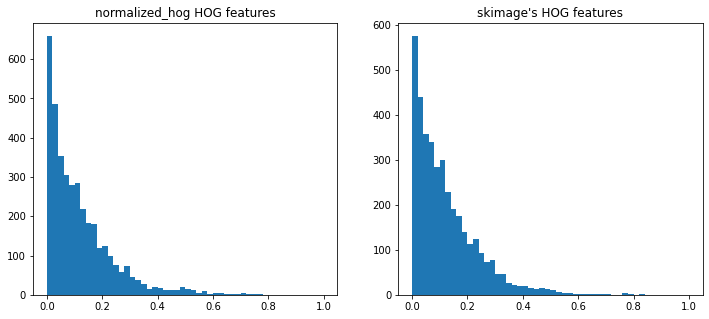

In [ ]:
# TO-DO (2 points): create and plot a histogram with your row vector of HOG features. The histogram's plot
# should have 50 bins and span from 0 to 1 in the x-axis. 
# Note: you are calculating the regular histogram, not the cumulative one. 

plt.figure(figsize = (12,5))
plt.subplot(1, 2, 1)
plt.title('normalized_hog HOG features')
plt.hist(normalized_hog, bins=50, range=(0,1))

# TO-DO (2 points): use skimage's "hog" function to calculate the HOG of your input image using the 
# same hyper parameters (i.e., n_bin=9, cell_size=8, blocks of 2x2, L2-norm) of the rest of the 
# assignment. The output should be flattened to a row vector. The dimensions of such 
# vector must match those that you manually calculated. Specify that you desire to visualize 
# the results in an output image. 

fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2', visualize=True)

assert fd.size==normalized_hog.size, 'The dimensions of the HOG feature vectors do no match.'

# TO-DO (2 points): create and plot a 50-bin histogram with skimage's HOG features. 
# Bound the plot's x-axis values into the [0,1] range. 
# Display this plot for an approximate comparison with your recently calculated one. 
#
#
plt.subplot(1, 2, 2)
plt.title('skimage\'s HOG features')
plt.hist(fd, bins=50, range=(0,1))
plt.show()

**Similarity calculation**. In order to guarantee that visualizing scikit-images' HOG features represents well your mannualy calculated HOG features, you are now asked to compare the level of similarity between these two row of features. We will use cosine similarity to accomplish that. 

Recall: the cosine similarity is given by the cosine of angle $\alpha$ formed between two multi-dimensional vectors A and B:

$cosineSimilarity(A,B) = cos(\alpha)=\frac{A\bullet B}{\|A\|\times\|B\|}= \frac{(\sum_{i=1}^{n}A_i \times B_i)}{\sqrt{\sum_{i=1}^{n}A_i^2}\times\sqrt{\sum_{i=1}^{n}B_i^2}}$ 

cosine similarity: 0.9507673690153495


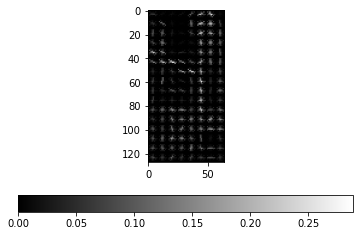

In [ ]:
# TO-DO (6 points): MANNUALY calculate the cosine similarity between these two feature vectors
# (i.e., HOG features calculated mannualy and using skimage). The cosine similarity is simply
# the cosine of the angle formed between the two vectors. Since the cosine of 0 (i.e., when
# the vectors have the same orientation) is 1 (maximum), this measure reflects if
# two multi-dimensional vectors point in the same direction. 
# YOU CAN ONLY USE "np.sqrt" and "np.dot" in this calculation. 

# Note 1: this metric does not consider the magniture of the two input vectors, only the 
# angle between them. 

# Note 2: in the cosine similarity formula, the numerator represents dot product,
# while the denominator represents the product of L2-norms. 

# let A be my manual hog feature, and B be the one using skimage
a, b = normalized_hog, fd

# cosine similarity calculation using only "np.sqrt" and "np.dot"
c_sim = np.dot(a,b) / ( np.sqrt(np.dot(a,a)) * np.sqrt(np.dot(b,b)) )

# TO-DO(1 point): print the cosine similarity calculated. If the HOG was correctly measured 
# both mannualy and automatically, the cosine similarity between "normalized_hog" and 
# "fd" should be higher than 0.95. To compensate for small differences, your 
# cosine similarity should be higher than AT LEAST 0.93.

print("cosine similarity:", c_sim)

assert c_sim>0.93, 'Cosine similarity lower than 0.93. Check your manual HOG calculations.'

# TO-DO (1 points): display the HOG image obtained as an output of skimage's "hog"
# function. Since the cosine similarity between the two HOG feature vectors is high,
# this is good approximation of HOG features you calculated mannualy.
#
#
_ = pltImg(hog_image)

**End of the assignment!**